# Document Setup

- Project ID: EMB_RemImb
- Researchers: DK
- Current Version: v1.0

See associated protocol for more details.

In [48]:
# Stdlib
import sys
import os
import random
from IPython.display import display, Latex
from datetime import datetime

# Scientific computing
import numpy as np

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Project source
sys.path.append("../../src/")
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [49]:
proj_id = "EMB_RemImb"
version = "v2.0"
researcher = "DK"
today = datetime.today().strftime("%Y%m%d")

filepath_root = "../../"
filepath_data = filepath_root + "data/input/preprocessed/real/duplex_system={}.edgelist"
filepath_dataframe = filepath_root + "results/dataframes/"
filepath_plots = filepath_root + "results/plots/"

# Experiment

## Preface

**Goal**

Explore embedding reconstruction (in)accuracy as a function of layer imbalance.

**Procedure**

1. Load real system duplex
2. Observe some fraction of _a priori_ information, $\theta$
3. Measure the relative size $\frac{|G_{\theta}|}{|H_{\theta}|}$
4. Repeat for all $\theta$
5. Repeat for all networks

## Prerequisite code

In [50]:
def wrapper_process_real_system(filepath, layer_idxs):
    duplex = utils.read_file(filepath)
    duplex = utils.duplex_network(duplex, *layer_idxs)
    return duplex

## Workflow

In [51]:
# * Experiment Parameters
# >>> Network topology <<<
layers = {
    "arxiv": [(2, 6), (2, 7), (6, 7)],
    "celegans": [(1, 2), (1, 3), (2, 3)],
    "drosophila": [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)],
    "london": [(1, 2), (1, 3), (2, 3)],
}  # induced duplexes
thetas = [
    float(np.format_float_positional(x, precision=2))
    for x in np.linspace(0.01, 1.0, 101, endpoint=True)
] # rewiring probability

# >>> Other <<<
repeat = 30  # number of simulations

In [53]:
# * Main Workflow
records = []

# Loop over networks
for system_, layer_pairs in layers.items():
    system_filepath = filepath_data.format(system_)

    # Loop over induced duplexes of current network
    for layer_pair in layer_pairs:
        D = wrapper_process_real_system(system_filepath, layer_pair)

        # Loop over PFI range
        for theta in tqdm(thetas, desc=f"{system_} - {layer_pair}"):
            rem_G, rem_H, _ = utils.partial_information(*D, frac=theta)

            # Calculate imbalances
            ratio_size = rem_G.number_of_edges() / rem_H.number_of_edges()
            _num, _den = (nx.average_clustering(rem_G), nx.average_clustering(rem_H))
            if _den == 0:
                ratio_clustering = -1
            else:
                ratio_clustering = _num / _den

            # Form record
            record = {
                "system": system_,
                "layers": layer_pair,
                "theta": theta,
                "size_imbalance": ratio_size,
                "clustering_imbalance": ratio_clustering
            }
            records.append(record)

london - (2, 3): 100%|██████████| 101/101 [00:00<00:00, 256.05it/s]


## Analysis

### Processing and cleanup

In [54]:
df = pd.DataFrame.from_records(records)

In [55]:
df.head()

,system,layers,theta,size_imbalance,clustering_imbalance
0,arxiv,"(2, 6)",0.01,1.004277,1.004015
1,arxiv,"(2, 6)",0.02,1.010448,1.010308
2,arxiv,"(2, 6)",0.03,1.013585,1.011634
3,arxiv,"(2, 6)",0.04,1.019112,1.022919
4,arxiv,"(2, 6)",0.05,1.023879,1.032319


### Visualizations

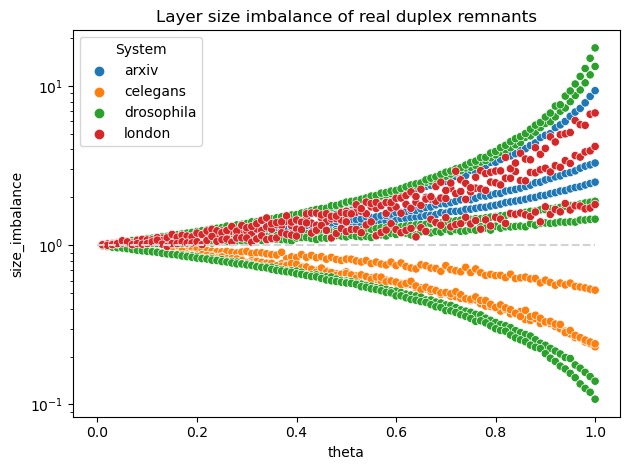

In [86]:
plt.figure()

sns.scatterplot(
    data=df,
    x="theta", y="size_imbalance",
    hue="system",
)
plt.hlines(1, 0, 1, color="lightgray", linestyle="dashed")

plt.yscale("log")

plt.legend(loc="upper left", title="System")
plt.title("Layer size imbalance of real duplex remnants")

plt.tight_layout()

plt.savefig(filepath_plots + "scatter_size-imbalance_EMB_RemImb.png", facecolor="white", transparent=False)

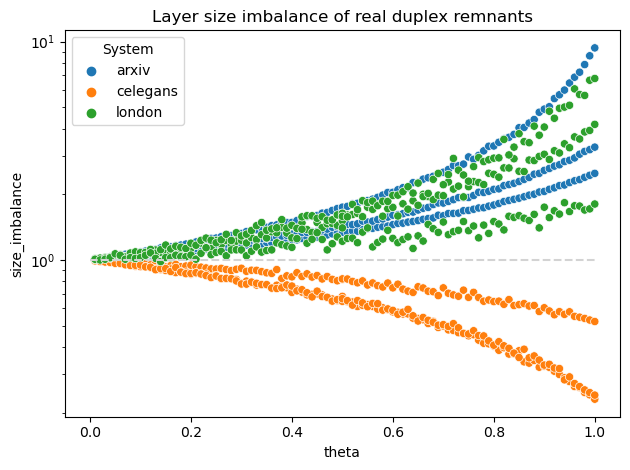

In [87]:
plt.figure()

sns.scatterplot(
    data=df.query("system != 'drosophila'"),
    x="theta", y="size_imbalance",
    hue="system",
)
plt.hlines(1, 0, 1, color="lightgray", linestyle="dashed")

plt.yscale("log")

plt.legend(loc="upper left", title="System")
plt.title("Layer size imbalance of real duplex remnants")

plt.tight_layout()

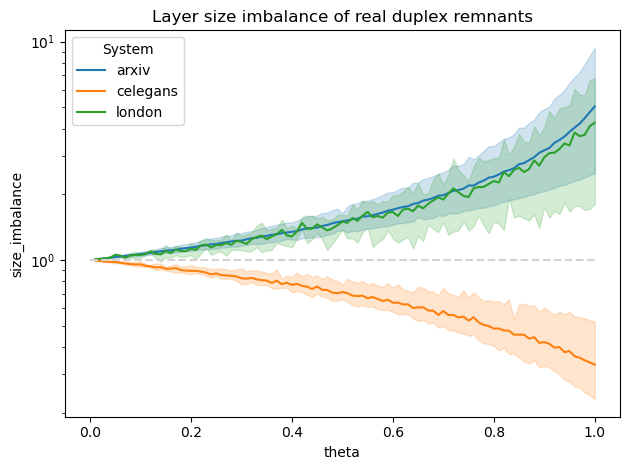

In [88]:
plt.figure()

sns.lineplot(
    data=df.query("system != 'drosophila'"),
    x="theta", y="size_imbalance",
    hue="system",
)
plt.hlines(1, 0, 1, color="lightgray", linestyle="dashed")

plt.yscale("log")

plt.legend(loc="upper left", title="System")
plt.title("Layer size imbalance of real duplex remnants")

plt.tight_layout()

plt.savefig(filepath_plots + "line_size-imbalance_EMB_RemImb.png", facecolor="white", transparent=False)

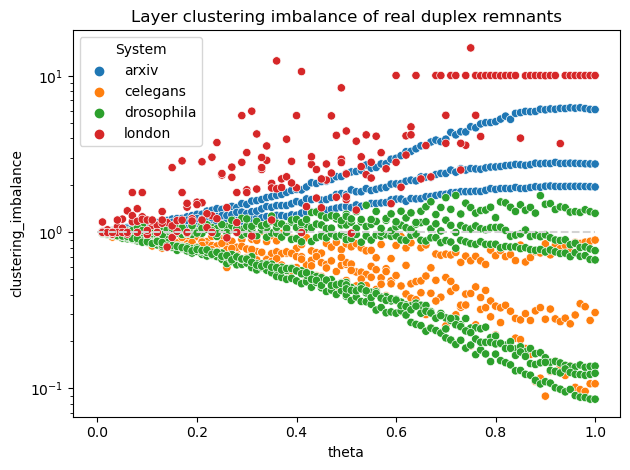

In [89]:
plt.figure()

sns.scatterplot(
    data=df.query("clustering_imbalance != -1"),
    x="theta", y="clustering_imbalance",
    hue="system",
)
plt.hlines(1, 0, 1, color="lightgray", linestyle="dashed")

plt.yscale("log")

plt.legend(loc="upper left", title="System")
plt.title("Layer clustering imbalance of real duplex remnants")

plt.tight_layout()

plt.savefig(filepath_plots + "scatter_clustering-imbalance_EMB_RemImb.png", facecolor="white", transparent=False)

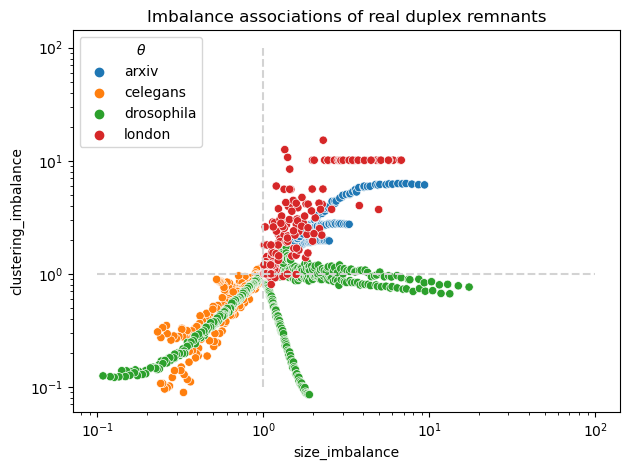

In [90]:
plt.figure()

sns.scatterplot(
    data=df.query("clustering_imbalance != -1"),
    x="size_imbalance", y="clustering_imbalance",
    hue="system"
)
plt.hlines(1, 10e-2, 10e1, color="lightgray", linestyle="dashed")
plt.vlines(1, 10e-2, 10e1, color="lightgray", linestyle="dashed")

plt.yscale("log")
plt.xscale("log")

plt.legend(loc="upper left", title="$ \\theta $")
plt.title("Imbalance associations of real duplex remnants")

plt.tight_layout()

plt.savefig(filepath_plots + "scatter_associations-imbalance_hue-system_EMB_RemImb.png", facecolor="white", transparent=False)

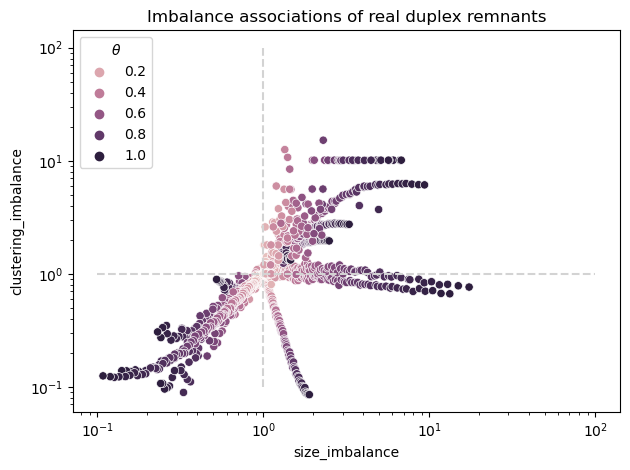

In [91]:
plt.figure()

sns.scatterplot(
    data=df.query("clustering_imbalance != -1"),
    x="size_imbalance", y="clustering_imbalance",
    hue="theta"
)
plt.hlines(1, 10e-2, 10e1, color="lightgray", linestyle="dashed")
plt.vlines(1, 10e-2, 10e1, color="lightgray", linestyle="dashed")

plt.yscale("log")
plt.xscale("log")

plt.legend(loc="upper left", title="$ \\theta $")
plt.title("Imbalance associations of real duplex remnants")

plt.tight_layout()

plt.savefig(filepath_plots + "scatter_associations-imbalance_hue-theta_EMB_RemImb.png", facecolor="white", transparent=False)